In [357]:
import xml.etree.ElementTree as ET
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [337]:
tree = ET.parse("../comparison-benchmark.xml")

In [338]:
root = tree.getroot()
cases = root.findall("*/TestCase")

results = []

for case in cases:
    case_name = case.get("name")

    for child in case.findall("Section"):
        section_name = child.get("name")
        decode_value = child.find(".//BenchmarkResults[@name='decode_value']")
        decode_view  = child.find(".//BenchmarkResults[@name='decode_view']")

        if decode_value:
            value_mean = float(decode_value.find("./mean").get("value"))
            value_stddev = float(decode_value.find("./standardDeviation").get("value"))
            
            results.append({
                "case" : case_name,
                "section": section_name,
                "type": "value",
                "mean": value_mean,
                "stddev": value_stddev
            })
        if decode_view: 
            view_mean = float(decode_view.find("./mean").get("value"))
            view_stddev = float(decode_view.find("./standardDeviation").get("value"))
    
            results.append({
                "case" : case_name,
                "section": section_name,
                "type": "view",
                "mean": view_mean,
                "stddev": view_stddev
            })

In [339]:
df = pd.DataFrame(results)

In [340]:
df["case"] = df["case"].apply(lambda x: x.replace("benchmark parsing - ", ""))
df["case"] = df['case'].astype("category")
df["section"] = df['section'].astype("category")
df["type"] = df['type'].astype("category")

In [341]:
df

,case,section,type,mean,stddev
0,fbdtemme/bencode,fedora workstation,value,12998.0,4184.48000
1,fbdtemme/bencode,fedora workstation,view,1052.0,105.96800
2,fbdtemme/bencode,NASA mdim_color,value,9887.0,1466.85000
3,fbdtemme/bencode,NASA mdim_color,view,3019.0,1370.64000
4,fbdtemme/bencode,COVID-19 image dataset,value,10215.0,2134.82000
5,fbdtemme/bencode,COVID-19 image dataset,view,2434.0,313.91900
6,jimporter/bencode,fedora workstation,value,12763.0,5236.14000
7,jimporter/bencode,fedora workstation,view,510.0,6.38113
8,jimporter/bencode,NASA mdim_color,value,9822.0,1199.32000
9,jimporter/bencode,NASA mdim_color,view,2347.0,315.29200


In [342]:
value_df = df.loc[df["type"] == "value", :]
value_df

,case,section,type,mean,stddev
0,fbdtemme/bencode,fedora workstation,value,12998.0,4184.48
2,fbdtemme/bencode,NASA mdim_color,value,9887.0,1466.85
4,fbdtemme/bencode,COVID-19 image dataset,value,10215.0,2134.82
6,jimporter/bencode,fedora workstation,value,12763.0,5236.14
8,jimporter/bencode,NASA mdim_color,value,9822.0,1199.32
10,jimporter/bencode,COVID-19 image dataset,value,11897.0,4062.69


In [343]:
view_df = df.loc[df["type"] == "view", :]
view_df

,case,section,type,mean,stddev
1,fbdtemme/bencode,fedora workstation,view,1052.0,105.96800
3,fbdtemme/bencode,NASA mdim_color,view,3019.0,1370.64000
5,fbdtemme/bencode,COVID-19 image dataset,view,2434.0,313.91900
7,jimporter/bencode,fedora workstation,view,510.0,6.38113
9,jimporter/bencode,NASA mdim_color,view,2347.0,315.29200
11,jimporter/bencode,COVID-19 image dataset,view,2400.0,49.78560


In [358]:
def plot_comparison(df):
    sections = df["section"].dtype.categories
    n_sections = len(sections)

    cases = df["case"].dtype.categories
    n_cases = len(cases)

    means = np.ndarray((n_cases, n_sections))

    for case_idx, case in enumerate(cases):
        m = df.loc[df["case"] == case, ("section", "mean")]
        m = m.set_index("section").reindex(sections)
        means[case_idx,:] = np.ravel(m)
        stddevs = np.ndarray((n_cases, n_sections))

    for case_idx, case in enumerate(cases):
        s = df.loc[df["case"] == case, ("section", "stddev")]
        s = s.set_index("section").reindex(sections)
        stddevs[case_idx,:] = np.ravel(s)

    fig, ax = plt.subplots()

    x = np.arange(n_sections)
    width = 0.2  # the width of the bars

    rects = []
    for i, (mean, stddev, case) in enumerate(zip(means, stddevs, cases)):
        rects.append(ax.bar(x + i*width, mean, width=width, yerr=stddev, label=case))

    ax.set_ylabel("Duration (ns)")

    # Set the position of the x ticks
    ax.set_xticks([p + 0.5 * width for p in x])
    # ax.set_xrot
    # Set the labels for the x ticks
    ax.set_xticklabels(sections)

    ax.legend(cases, bbox_to_anchor=(1.05, 1), loc='upper left')

    return ax

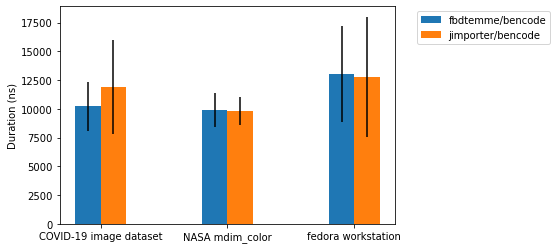

In [359]:
ax = plot_comparison(value_df)
plt.savefig("comparison_value.svg")

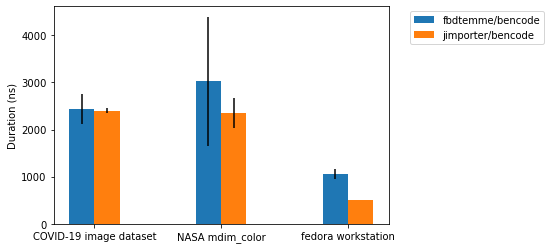

In [360]:
plot_comparison(view_df)
plt.savefig("comparison_view.svg")